# Assignment 2 - Kaggle Competition

# Store Item Demand Forecasting Challenge

## Abstract

The aim of this assignment is to learn how the H2O's AutoML can be used to predict the sales of the "Store Item Demand" dataset.

the dataset which was given us are the sales data of 3 years of 10 different stores and asked us to predict the sales of the next two years, basically the dataset is a time series and asked us to forecast the sales of the next two years

Artificial Intelligence…at this point you know that it is the wave of the future, going to make you very rich if you add it to your career’s skills list and eventually going to kill us all. As those first two points excite the average person, the next step is usually them trying to figure out how to learn more about the field. They typically find an online course or some introduction where after, the logical progression is to get some hands on experience. That is when they run into what I like to call the “tooling issue.”

**H2O.ai** is the company behind open-source Machine Learning (ML) products like H2O, aimed to make ML easier for all. Their open-source community includes more than 129,000 data scientists and 12,000 organizations. They also have almost half of the Fortune 500 using their software with a 330% growth in users over the past two years. Analyst have also taken note as they’ve been classified as a Leader with the most completeness of vision, among 16 vendors included in Gartner’s 2018 Magic Quadrant for Data Science and Machine Learning Platforms. Their business partners include major players like Microsoft, IBM, NVIDIA, Splunk, Databricks, MapR, Anaconda, Cloudera and a few others. So how did they gain such a large following? By mostly delivering on their promise to make machine learning accessible and allow business users to extract insights from data, without needing expertise in deploying or tuning machine learning models.

H2O. The primary offering. An open source, in-memory, distributed, ML and predictive analytics platform allowing you to build and productionize ML models. Contains supervised and unsupervised models like GLM and K-Means clustering, and a simple to use web-UI called Flow.



As we know the dataset and from the below visualization the sales of the stores are increasing by the year but at the same time the sales by the month if we see, the trend is seasonal.

In this notebook we have forecasted using H20 and also XGboost.

## Dataset

The dataset has the data of 5 years of store-item sales data, and asked to predict 3 months of sales for 50 different items at 10 different stores.

**Data fields**

**date:** Date of the sale data. There are no holiday effects or store closures.

**store:** Store ID

**item:** Item ID

**sales:** Number of items sold at a particular store on a particular date


As the dataset has sales attribute and we need to predict the sales of the store. we can say that this is a time series dataset, so we will use regression technique to predict the value by making use of **H2O AI's AutoML**

We can start by importing all the basic libraries and also by importing the dataset to the kernel

Import all the libraies which we will be needing for the notebook to run

In [18]:
import os
import h2o
import pandas as pd
import datetime as dt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pandas import Series
import csv
import plotly as plotly
%matplotlib inline
import pandas_profiling as pp
import warnings
warnings.filterwarnings('ignore')
import plotly.plotly as py
import scipy.stats as st
import seaborn as sns
sns.set(style="white", palette="muted", color_codes=True)
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go

Now as the libraries imported to the notebook, we will proceed with importing the dataset which we will be using in this kernel to train our model.

the data type of the columns are changed for the EDA process

In [19]:
data_type = {'store': 'int8', 'item': 'int8', 'sales': 'int16'}

In [3]:
features = pd.read_csv('train.csv',parse_dates= ['date'], dtype= data_type)

In [4]:
features.head()

date  store  item  sales
0 2013-01-01      1     1     13
1 2013-01-02      1     1     11
2 2013-01-03      1     1     14
3 2013-01-04      1     1     13
4 2013-01-05      1     1     10

In [20]:
features.describe()

store           item          sales
count  913000.000000  913000.000000  913000.000000
mean        5.500000      25.500000      52.250287
std         2.872283      14.430878      28.801144
min         1.000000       1.000000       0.000000
25%         3.000000      13.000000      30.000000
50%         5.500000      25.500000      47.000000
75%         8.000000      38.000000      70.000000
max        10.000000      50.000000     231.000000

we profile all the columns using pandas profiling 

In [6]:
pp.ProfileReport(features)

## Distribution of the sales

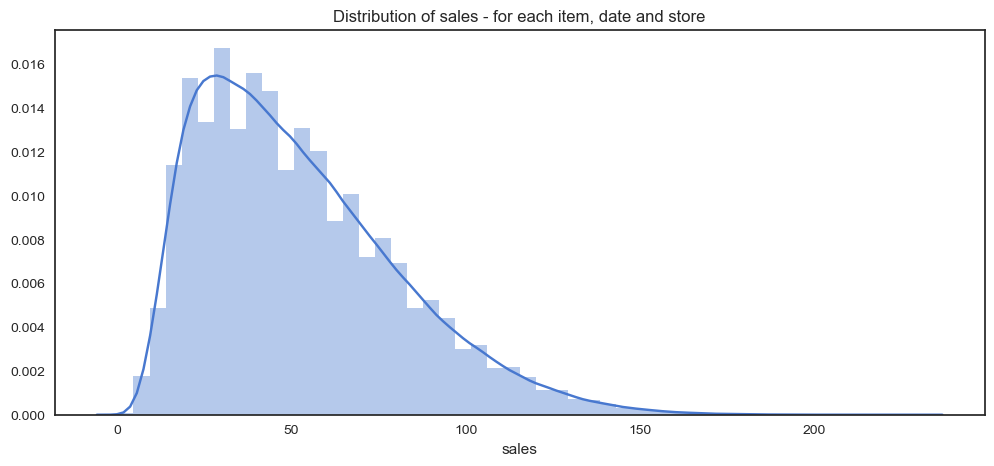

In [8]:
plt.figure(figsize=(12,5))
plt.title("Distribution of sales - for each item, date and store")
ax = sns.distplot(features['sales'])

## Distribution of sales vs best fit normal distribution

p-value for sales distribution: 0.0


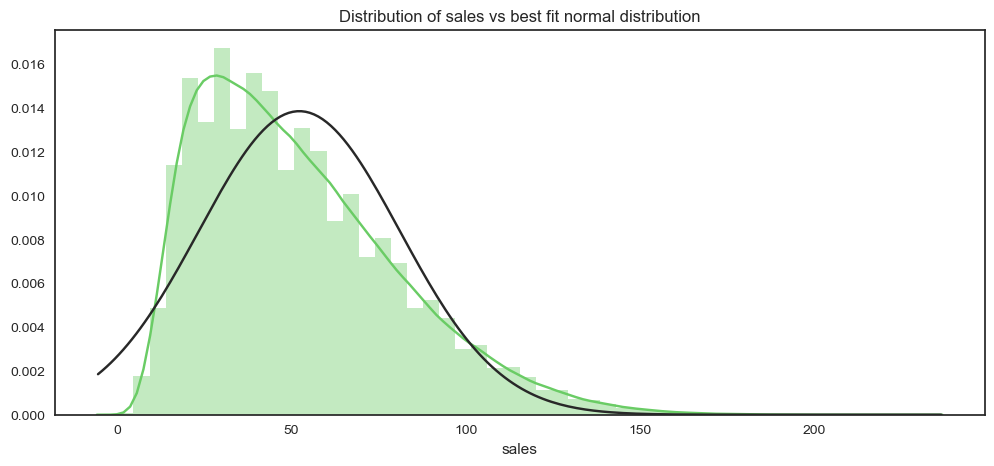

In [9]:
print("p-value for sales distribution: {}".format(st.normaltest(features.sales.values)[1]))
plt.figure(figsize=(12,5))
plt.title("Distribution of sales vs best fit normal distribution")
ax = sns.distplot(features.sales, fit= st.norm, kde=True, color='g')

In [10]:

import plotly.offline as py
py.init_notebook_mode()


# Total sales
Graph of average monthly sales for all stores and items:

In [11]:
monthly_df = features.groupby([features.date.dt.year, features.date.dt.month])['sales'].mean()
monthly_df.index = monthly_df.index.set_names(['year', 'month'])
monthly_df = monthly_df.reset_index()
x_axis = []
for y in range(13, 18):
    for m in range(1,12):
        x_axis.append("{}/{}".format(m,y))
trace = go.Scatter(x= x_axis, y= monthly_df.sales, mode= 'lines+markers', name= 'sales avg per month', line=dict(width=3))
layout = go.Layout(autosize=True, title= 'Sales - average per month', showlegend=True)
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

Sales are slowing increasing each year and there is a clear **seasonality effect**


## Total sales by year

In [12]:
year_df = features.groupby(features.date.dt.year)['sales'].sum().to_frame()

trace = go.Bar(
    y= year_df.sales, x= ['2013','2014','2015','2016','2017'],
    marker=dict(color='rgba(179, 143, 0, 0.6)', line=dict(color='rgba(179, 143, 0, 1.0)', width=1)),
    name='Total sales by year', orientation='v'
)

layout = go.Layout(autosize=False, title= 'Total sales by year', showlegend=True, width=600, height=400)
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)


# Sales by store
Average sales per month and store:

In [13]:
monthly_df = features.groupby([features.date.dt.year, features.date.dt.month, 'store']).mean()
monthly_df.index = monthly_df.index.set_names(['year', 'month', 'store'])
monthly_df = monthly_df.reset_index()

traces = []
for i in range(1, 11):
    store_sales = monthly_df[monthly_df.store == i]
    trace = go.Scatter(x= x_axis, y= store_sales.sales, mode= 'lines+markers', name= 'Store '+str(i), line=dict(width=3))
    traces.append(trace)
layout = go.Layout(autosize=True, title= 'Sales - average per month', showlegend=True)
fig = go.Figure(traces, layout=layout)
iplot(fig)

# Sales per store - bar chart

In [14]:
store_total = features.groupby(['store'])['sales'].sum().to_frame().reset_index()
store_total.sort_values(by = ['sales'], ascending=True, inplace=True)
labels = ['Store {}'.format(i) for i in store_total.store]

trace = go.Bar(
    y= store_total.sales, x= labels,
    marker=dict(color='rgba(255, 65, 54, 0.6)', line=dict(color='rgba(255, 65, 54, 1.0)', width=1)),
    name='Total sales per store', orientation='v'
)

layout = go.Layout(autosize=True, title= 'Total sales by store')
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

# Sales BoxPlot for each store


In [15]:
store_sum = features.groupby(['store', 'date'])['sales'].sum()
traces = []

for i in range(1, 11):
    s = store_sum[i].to_frame().reset_index()
    trace = go.Box(y= s.sales, name= 'Store {}'.format(i), jitter=0.8, whiskerwidth=0.2, marker=dict(size=2), line=dict(width=1))
    traces.append(trace)

layout = go.Layout(
    title='Sales BoxPlot for each store',
    yaxis=dict(
        autorange=True, showgrid=True, zeroline=True,
        gridcolor='rgb(233,233,233)', zerolinecolor='rgb(255, 255, 255)',
        zerolinewidth=2, gridwidth=1
    ),
    margin=dict(l=40, r=30, b=80, t=100), showlegend=False,
)

fig = go.Figure(data=traces, layout=layout)
iplot(fig)

# Sales by item
We have 50 different products with total sales that goes from 335k for Item 5 to 1.6M for item 15.

In [16]:
item_total = features.groupby(['item'])['sales'].sum().to_frame().reset_index()
item_total.sort_values(by = ['sales'], ascending=False, inplace=True)
labels = ['Item {}'.format(i) for i in item_total.item]

trace = go.Bar(
    y= item_total.sales, x= labels,
    marker=dict(color='rgba(33, 33, 135, 0.6)', line=dict(color='rgba(33, 33, 135, 1.0)', width=1)),
    name='Total sales by item', orientation='v'
)
layout = go.Layout(autosize=True, title= 'Sales per item (all time)')
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

# Sales BoxPlot for each item


In [17]:
item_sum = features.groupby(['item', 'date'])['sales'].sum()
traces = []

for i in range(1, 51):
    s = item_sum[i].to_frame().reset_index()
    trace = go.Box(y= s.sales, name= 'Item {}'.format(i), jitter=0.8, whiskerwidth=0.2, marker=dict(size=2), line=dict(width=1))
    traces.append(trace)

layout = go.Layout(
    title='Sales BoxPlot for each item',
    yaxis=dict(
        autorange=True, showgrid=True, zeroline=True,
        gridcolor='rgb(233,233,233)', zerolinecolor='rgb(255, 255, 255)',
        zerolinewidth=2, gridwidth=1
    ),
    margin=dict(l=40, r=30, b=80, t=100), showlegend=False,
)

fig = go.Figure(data=traces, layout=layout)
iplot(fig)


# H2O AutoML

Import the H2O library and initilaze it with the memory size of 20 GB

In [8]:
from h2o.automl import H2OAutoML
h2o.init(max_mem_size = "20G")

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; OpenJDK 64-Bit Server VM (build 25.152-b12, mixed mode)56-b12)
  Starting server from C:\Users\cheta\Anaconda3\h2o_jar\h2o.jar
  Ice root: C:\Users\cheta\AppData\Local\Temp\tmpa73bm1a1
  JVM stdout: C:\Users\cheta\AppData\Local\Temp\tmpa73bm1a1\h2o_cheta_started_from_python.out
  JVM stderr: C:\Users\cheta\AppData\Local\Temp\tmpa73bm1a1\h2o_cheta_started_from_python.err
  Server is running at http://127.0.0.1:54323
Connecting to H2O server at http://127.0.0.1:54323... successful.


--------------------------  -------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       America/New_York
H2O data parsing timezone:  UTC
H2O cluster version:        3.18.0.2
H2O cluster version age:    11 months and 21 days !!!
H2O cluster name:           H2O_from_python_cheta_msv1ng
H2O cluster total nodes:    1
H2O cluster free memory:    17.78 Gb
H2O cluster total cores:    8
H2O cluster allowed cores:  8
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54323
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Algos, AutoML, Core V3, Core V4
Python version:             3.6.5 final
--------------------------  -------------------------------

Load the files to the Jupyter notebook both train dataset and the test dataset

In [9]:
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [10]:
df.describe()

store           item          sales
count  913000.000000  913000.000000  913000.000000
mean        5.500000      25.500000      52.250287
std         2.872283      14.430878      28.801144
min         1.000000       1.000000       0.000000
25%         3.000000      13.000000      30.000000
50%         5.500000      25.500000      47.000000
75%         8.000000      38.000000      70.000000
max        10.000000      50.000000     231.000000

In [11]:
df_test.describe()

id         store         item
count  45000.000000  45000.000000  45000.00000
mean   22499.500000      5.500000     25.50000
std    12990.525394      2.872313     14.43103
min        0.000000      1.000000      1.00000
25%    11249.750000      3.000000     13.00000
50%    22499.500000      5.500000     25.50000
75%    33749.250000      8.000000     38.00000
max    44999.000000     10.000000     50.00000

In [12]:
df.head()

date  store  item  sales
0  2013-01-01      1     1     13
1  2013-01-02      1     1     11
2  2013-01-03      1     1     14
3  2013-01-04      1     1     13
4  2013-01-05      1     1     10

In [13]:
df_test.head()

id        date  store  item
0   0  2018-01-01      1     1
1   1  2018-01-02      1     1
2   2  2018-01-03      1     1
3   3  2018-01-04      1     1
4   4  2018-01-05      1     1

Convert the date datatype to datetime and store it in the variable which we created

In [14]:
df['date'] = pd.to_datetime(df['date'])
print(df['date'].dtype)

datetime64[ns]


In [15]:
df_test['date'] = pd.to_datetime(df_test['date'])
print(df_test['date'].dtype)

datetime64[ns]


split the date column into Year, Month, Weekday, and quarter to enhance the granularity

In [16]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['weekday'] = df['date'].dt.weekday
df['quarter'] = df['year'] * 4 + divmod(df['month'], 3)[0] - 8051
df.head()

date  store  item  sales  year  month  weekday  quoter
0 2013-01-01      1     1     13  2013      1        1       1
1 2013-01-02      1     1     11  2013      1        2       1
2 2013-01-03      1     1     14  2013      1        3       1
3 2013-01-04      1     1     13  2013      1        4       1
4 2013-01-05      1     1     10  2013      1        5       1

same for the test dataset

In [17]:
df_test['year'] = df_test['date'].dt.year
df_test['month'] = df_test['date'].dt.month
df_test['weekday'] = df_test['date'].dt.weekday
df_test['quarter'] = df_test['year'] * 4 + divmod(df_test['month'], 3)[0] - 8051
df_test.head()

id       date  store  item  year  month  weekday  quoter
0   0 2018-01-01      1     1  2018      1        0      21
1   1 2018-01-02      1     1  2018      1        1      21
2   2 2018-01-03      1     1  2018      1        2      21
3   3 2018-01-04      1     1  2018      1        3      21
4   4 2018-01-05      1     1  2018      1        4      21

add the columns such as "item_store_month_sales", "store_item_weekday_sales", "round_item_store_month_sales", and "round_store_item_weekday_sales"

In [18]:
df['item_store_month_sales'] = df.groupby(['item', 'store', 'month'])['sales'].transform('mean')
df['store_item_weekday_sales'] = df.groupby(['store', 'item', 'weekday'])['sales'].transform('mean')
df['round_item_store_month_sales'] = round(df['item_store_month_sales'])
df['round_store_item_weekday_sales'] = round(df['store_item_weekday_sales'])
df.head()

date  store  item  sales  year  month  weekday  quoter  \
0 2013-01-01      1     1     13  2013      1        1       1   
1 2013-01-02      1     1     11  2013      1        2       1   
2 2013-01-03      1     1     14  2013      1        3       1   
3 2013-01-04      1     1     13  2013      1        4       1   
4 2013-01-05      1     1     10  2013      1        5       1   

   item_store_month_sales  store_item_weekday_sales  \
0               13.709677                 18.168582   
1               13.709677                 18.793103   
2               13.709677                 19.452107   
3               13.709677                 21.015326   
4               13.709677                 22.973180   

   round_item_store_month_sales  round_store_item_weekday_sales  
0                          14.0                            18.0  
1                          14.0                            19.0  
2                          14.0                            19.0  
3                          14.0                            21.0  
4                          14.0                            23.0

In [19]:
df_select = df[['sales', \
                'month', \
                'quarter', \
                'item_store_month_sales', \
                'store_item_weekday_sales', \
                'round_item_store_month_sales', \
                'round_store_item_weekday_sales']]

add the columns to the H2O data frame so that we can train the model using the training dataset and test dataset

In [20]:
htrain = h2o.H2OFrame(df)

C:\Users\cheta\Anaconda3\lib\site-packages\h2o\utils\shared_utils.py:170: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = _handle_python_lists(python_obj.as_matrix().tolist(), -1)[1]


Parse progress: |█████████████████████████████████████████████████████████| 100%


In [21]:
htest =h2o.H2OFrame(df_test)

C:\Users\cheta\Anaconda3\lib\site-packages\h2o\utils\shared_utils.py:170: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = _handle_python_lists(python_obj.as_matrix().tolist(), -1)[1]


Parse progress: |█████████████████████████████████████████████████████████| 100%


In [22]:
htrain.head()

date store item sales year month weekday quoter item_store_month_sales store_item_weekday_sales round_item_store_month_sales round_store_item_weekday_sales 
 
 
 2013-01-01 00:00:00 1 1 13 2013 1 1 1 13.7097 18.1686 14 18 
 2013-01-02 00:00:00 1 1 11 2013 1 2 1 13.7097 18.7931 14 19 
 2013-01-03 00:00:00 1 1 14 2013 1 3 1 13.7097 19.4521 14 19 
 2013-01-04 00:00:00 1 1 13 2013 1 4 1 13.7097 21.0153 14 21 
 2013-01-05 00:00:00 1 1 10 2013 1 5 1 13.7097 22.9732 14 23 
 2013-01-06 00:00:00 1 1 12 2013 1 6 1 13.7097 23.7969 14 24 
 2013-01-07 00:00:00 1 1 10 2013 1 0 1 13.7097 15.5846 14 16 
 2013-01-08 00:00:00 1 1 9 2013 1 1 1 13.7097 18.1686 14 18 
 2013-01-09 00:00:00 1 1 12 2013 1 2 1 13.7097 18.7931 14 19 
 2013-01-10 00:00:00 1 1 9 2013 1 3 1 13.7097 19.4521 14 19

In [23]:
htest.head()

id date store item year month weekday quoter 
 
 
 0 2018-01-01 00:00:00 1 1 2018 1 0 21 
 1 2018-01-02 00:00:00 1 1 2018 1 1 21 
 2 2018-01-03 00:00:00 1 1 2018 1 2 21 
 3 2018-01-04 00:00:00 1 1 2018 1 3 21 
 4 2018-01-05 00:00:00 1 1 2018 1 4 21 
 5 2018-01-06 00:00:00 1 1 2018 1 5 21 
 6 2018-01-07 00:00:00 1 1 2018 1 6 21 
 7 2018-01-08 00:00:00 1 1 2018 1 0 21 
 8 2018-01-09 00:00:00 1 1 2018 1 1 21 
 9 2018-01-10 00:00:00 1 1 2018 1 2 21

add the columns to the variable X

In [24]:
x = htrain.columns
x


['date',
 'store',
 'item',
 'sales',
 'year',
 'month',
 'weekday',
 'quoter',
 'item_store_month_sales',
 'store_item_weekday_sales',
 'round_item_store_month_sales',
 'round_store_item_weekday_sales']

add the column Sales to the "Y"

In [25]:
y= 'sales'
y

'sales'

Remove the sales part of the column from the X

In [26]:
x.remove(y)
x

['date',
 'store',
 'item',
 'year',
 'month',
 'weekday',
 'quoter',
 'item_store_month_sales',
 'store_item_weekday_sales',
 'round_item_store_month_sales',
 'round_store_item_weekday_sales']

Initialize the H2OAUTOML with the model as max of 6 and then train the model with loading variable x, y and training frame as h_train

In [28]:
aml = H2OAutoML(max_models=6)
aml

In [29]:
aml.train(x=x, y =y, training_frame=htrain)

AutoML progress: |████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


Checking how the models did by ising leaderboard component of the automl

In [30]:
lb = aml.leaderboard
print (lb)

model_id mean_residual_deviance rmse mae rmsle 
 
 
 StackedEnsemble_AllModels_0_AutoML_20190301_165902 52.2681 7.22967 5.56463 0.160883 
 GBM_grid_0_AutoML_20190301_165902_model_0 52.3001 7.23188 5.56617 0.161031 
 GBM_grid_0_AutoML_20190301_165902_model_1 52.3342 7.23424 5.56813 0.16109 
 GBM_grid_0_AutoML_20190301_165902_model_2 52.3495 7.2353 5.56848 0.161056 
 StackedEnsemble_BestOfFamily_0_AutoML_20190301_165902 52.8024 7.26653 5.59302 0.161693 
 XRT_0_AutoML_20190301_165902 58.3746 7.64032 5.87097 0.169014 
 DRF_0_AutoML_20190301_165902 60.3513 7.76861 5.96991 0.171849 
 GLM_grid_0_AutoML_20190301_165902_model_0 71.5281 8.45743 6.53216 nan

Preduicting the sales by running the trained model on the Htest dataset and then storing it in the variable test_y

In [31]:
test_y = aml.leader.predict(htest)
test_y = test_y.as_data_frame()

stackedensemble prediction progress: |████████████████████████████████████| 100%


C:\Users\cheta\Anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset is missing column 'item_store_month_sales': substituting in a column of NaN
  warnings.warn(w)
C:\Users\cheta\Anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset is missing column 'store_item_weekday_sales': substituting in a column of NaN
  warnings.warn(w)
C:\Users\cheta\Anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset is missing column 'round_item_store_month_sales': substituting in a column of NaN
  warnings.warn(w)
C:\Users\cheta\Anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset is missing column 'round_store_item_weekday_sales': substituting in a column of NaN
  warnings.warn(w)


In [32]:
test_y.head()

predict
0  30.372581
1  33.937982
2  34.101103
3  35.304044
4  37.284435

checking the leaderboard and the leader who did the best amongst other models

In [33]:
aml.leaderboard
aml.leader

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_0_AutoML_20190301_165902
No model summary for this model


ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 49.680501471218435
RMSE: 7.0484396479801426
MAE: 5.432099703738508
RMSLE: 0.15737770859137648
R^2: 0.9400181977922605
Mean Residual Deviance: 49.680501471218435
Null degrees of freedom: 729869
Residual degrees of freedom: 729863
Null deviance: 604521809.5184216
Residual deviance: 36260307.6087982
AIC: 4921886.752899384

ModelMetricsRegressionGLM: stackedensemble
** Reported on validation data. **

MSE: 52.4588176604543
RMSE: 7.242845964153476
MAE: 5.566549420176421
RMSLE: 0.16072911562697656
R^2: 0.9371349328560984
Mean Residual Deviance: 52.4588176604543
Null degrees of freedom: 183129
Residual degrees of freedom: 183123
Null deviance: 152816298.08295864
Residual deviance: 9606783.278158996
AIC: 1244916.4347037897

ModelMetricsRegressionGLM: stackeden

In [27]:
print(' H2O automl leader performace : ', aml.leader)

 H2O automl leader performace :  Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_0_AutoML_20190228_132606
No model summary for this model


ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 51.719254826590664
RMSE: 7.191610030208164
MAE: 5.538545365633685
RMSLE: 0.16030752364581263
R^2: 0.9375567069278186
Mean Residual Deviance: 51.719254826590664
Null degrees of freedom: 729869
Residual degrees of freedom: 729866
Null deviance: 604521809.5184216
Residual deviance: 37748332.52028373
AIC: 4951234.383092979

ModelMetricsRegressionGLM: stackedensemble
** Reported on validation data. **

MSE: 52.44024735829748
RMSE: 7.241563875178999
MAE: 5.565613147630938
RMSLE: 0.16070904236375255
R^2: 0.9371571869469079
Mean Residual Deviance: 52.44024735829748
Null degrees of freedom: 183129
Residual degrees of freedom: 183126
Null deviance: 152816298.08295864
Residual deviance: 9603382.498725018
AIC: 1244845.5956231193

M

adding the output to the CSV files and submitting it to the competition

In [34]:
sample_submission = pd.read_csv(os.path.expanduser('sample_submission.csv'))
sample_submission['sales'] = test_y.astype('int')
sample_submission['id'] = sample_submission['id'].astype('str')

In [35]:
sample_submission.to_csv('submission.csv', index=False)

shutting down the H2O cluster so we allocate the memory for the other usage.

In [36]:
h2o.cluster().shutdown()

H2O session _sid_824d closed.


## XGBOOST

Importing the Xgboost library

In [22]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
import os

Importing the test and training dataset

In [23]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample = pd.read_csv("sample_submission.csv")

In [25]:
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

In [27]:
train['month'] = train['date'].dt.month
train['day'] = train['date'].dt.dayofweek
train['year'] = train['date'].dt.year
test['month'] = test['date'].dt.month
test['day'] = test['date'].dt.dayofweek
test['year'] = test['date'].dt.year

In [28]:
col = [i for i in test.columns if i not in ['date','id']]
y = 'sales'

In [30]:
#split the data into training data and test data

train_x, train_cv, y, y_cv = train_test_split(train[col],train[y], test_size=0.2, random_state=2018)

creating the model with all the parameters which we will use to train the model using XGB

In [31]:
def XGB_regressor(train_X, train_y, test_X, test_y, feature_names=None, seed_val=2017, num_rounds=2500):
    param = {}
    param['objective'] = 'reg:linear'
    param['eta'] = 0.025
    param['max_depth'] = 7
    param['silent'] = 1
    param['eval_metric'] = 'mae'
    param['min_child_weight'] = 1
    param['subsample'] = 0.7
    param['colsample_bytree'] = 0.7
    param['seed'] = seed_val
    num_rounds = num_rounds

    plst = list(param.items())

    xgtrain = xgb.DMatrix(train_X, label=train_y)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=20)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)
        
    return model    
 

Train the model and then predict the same with the trained model

In [33]:
model = XGB_regressor(train_X = train_x, train_y = y, test_X = train_cv, test_y = y_cv)
y_test = model.predict(xgb.DMatrix(test[col]), ntree_limit = model.best_ntree_limit)

[0]	train-mae:50.4717	test-mae:50.3982
Multiple eval metrics have been passed: 'test-mae' will be used for early stopping.

Will train until test-mae hasn't improved in 20 rounds.
[1]	train-mae:49.2106	test-mae:49.1368
[2]	train-mae:47.9803	test-mae:47.9058
[3]	train-mae:46.7818	test-mae:46.7078
[4]	train-mae:45.6132	test-mae:45.5392
[5]	train-mae:44.4735	test-mae:44.4002
[6]	train-mae:43.3626	test-mae:43.2893
[7]	train-mae:42.2815	test-mae:42.208
[8]	train-mae:41.2287	test-mae:41.155
[9]	train-mae:40.2044	test-mae:40.1318
[10]	train-mae:39.2062	test-mae:39.1346
[11]	train-mae:38.2366	test-mae:38.1668
[12]	train-mae:37.2962	test-mae:37.2276
[13]	train-mae:36.3844	test-mae:36.3158
[14]	train-mae:35.5002	test-mae:35.4324
[15]	train-mae:34.643	test-mae:34.5767
[16]	train-mae:33.8153	test-mae:33.7495
[17]	train-mae:33.0105	test-mae:32.9462
[18]	train-mae:32.2366	test-mae:32.172
[19]	train-mae:31.4907	test-mae:31.4262
[20]	train-mae:30.7714	test-mae:30.7082
[21]	train-mae:30.0854	test-mae:3

[200]	train-mae:8.93881	test-mae:8.9315
[201]	train-mae:8.88785	test-mae:8.88096
[202]	train-mae:8.83679	test-mae:8.8299
[203]	train-mae:8.78699	test-mae:8.78011
[204]	train-mae:8.78331	test-mae:8.77623
[205]	train-mae:8.7799	test-mae:8.77271
[206]	train-mae:8.77637	test-mae:8.76901
[207]	train-mae:8.75912	test-mae:8.75166
[208]	train-mae:8.71325	test-mae:8.70555
[209]	train-mae:8.66205	test-mae:8.65432
[210]	train-mae:8.61834	test-mae:8.61044
[211]	train-mae:8.57696	test-mae:8.56916
[212]	train-mae:8.56019	test-mae:8.55218
[213]	train-mae:8.53405	test-mae:8.52615
[214]	train-mae:8.48862	test-mae:8.48099
[215]	train-mae:8.44892	test-mae:8.44122
[216]	train-mae:8.41099	test-mae:8.4032
[217]	train-mae:8.40784	test-mae:8.3999
[218]	train-mae:8.36504	test-mae:8.35746
[219]	train-mae:8.32217	test-mae:8.31467
[220]	train-mae:8.2995	test-mae:8.29236
[221]	train-mae:8.28548	test-mae:8.27834
[222]	train-mae:8.28049	test-mae:8.2731
[223]	train-mae:8.27602	test-mae:8.26853
[224]	train-mae:8.27131

[402]	train-mae:6.6591	test-mae:6.65469
[403]	train-mae:6.65135	test-mae:6.64708
[404]	train-mae:6.65121	test-mae:6.6469
[405]	train-mae:6.64884	test-mae:6.64452
[406]	train-mae:6.63951	test-mae:6.63558
[407]	train-mae:6.63331	test-mae:6.62934
[408]	train-mae:6.62965	test-mae:6.62575
[409]	train-mae:6.61939	test-mae:6.6158
[410]	train-mae:6.6096	test-mae:6.60633
[411]	train-mae:6.60576	test-mae:6.60244
[412]	train-mae:6.6055	test-mae:6.60212
[413]	train-mae:6.6052	test-mae:6.6018
[414]	train-mae:6.60243	test-mae:6.59889
[415]	train-mae:6.59513	test-mae:6.59169
[416]	train-mae:6.58813	test-mae:6.58476
[417]	train-mae:6.58803	test-mae:6.58462
[418]	train-mae:6.5878	test-mae:6.58437
[419]	train-mae:6.58073	test-mae:6.57745
[420]	train-mae:6.57817	test-mae:6.57486
[421]	train-mae:6.57798	test-mae:6.57463
[422]	train-mae:6.57418	test-mae:6.57092
[423]	train-mae:6.57395	test-mae:6.57061
[424]	train-mae:6.57384	test-mae:6.57046
[425]	train-mae:6.57377	test-mae:6.57035
[426]	train-mae:6.57368	

[604]	train-mae:6.21781	test-mae:6.21861
[605]	train-mae:6.21577	test-mae:6.21661
[606]	train-mae:6.21467	test-mae:6.21554
[607]	train-mae:6.2124	test-mae:6.21343
[608]	train-mae:6.20844	test-mae:6.20958
[609]	train-mae:6.20748	test-mae:6.20865
[610]	train-mae:6.2059	test-mae:6.20707
[611]	train-mae:6.20314	test-mae:6.2044
[612]	train-mae:6.20317	test-mae:6.20443
[613]	train-mae:6.20319	test-mae:6.20441
[614]	train-mae:6.20324	test-mae:6.20444
[615]	train-mae:6.20328	test-mae:6.20447
[616]	train-mae:6.20325	test-mae:6.20445
[617]	train-mae:6.2021	test-mae:6.2033
[618]	train-mae:6.20211	test-mae:6.20331
[619]	train-mae:6.20123	test-mae:6.20249
[620]	train-mae:6.20034	test-mae:6.20169
[621]	train-mae:6.19876	test-mae:6.20012
[622]	train-mae:6.19766	test-mae:6.19906
[623]	train-mae:6.19514	test-mae:6.1965
[624]	train-mae:6.19373	test-mae:6.19516
[625]	train-mae:6.1901	test-mae:6.19168
[626]	train-mae:6.18833	test-mae:6.18995
[627]	train-mae:6.18836	test-mae:6.18999
[628]	train-mae:6.1871	

[806]	train-mae:6.01808	test-mae:6.02411
[807]	train-mae:6.0166	test-mae:6.02277
[808]	train-mae:6.01661	test-mae:6.02277
[809]	train-mae:6.01626	test-mae:6.02245
[810]	train-mae:6.01489	test-mae:6.02113
[811]	train-mae:6.01469	test-mae:6.02099
[812]	train-mae:6.01023	test-mae:6.0167
[813]	train-mae:6.01025	test-mae:6.01673
[814]	train-mae:6.01027	test-mae:6.01673
[815]	train-mae:6.0103	test-mae:6.01675
[816]	train-mae:6.01031	test-mae:6.01676
[817]	train-mae:6.00968	test-mae:6.01617
[818]	train-mae:6.00812	test-mae:6.01474
[819]	train-mae:6.00814	test-mae:6.01475
[820]	train-mae:6.00557	test-mae:6.0122
[821]	train-mae:6.00515	test-mae:6.01178
[822]	train-mae:6.00362	test-mae:6.01027
[823]	train-mae:6.00082	test-mae:6.0077
[824]	train-mae:6.00084	test-mae:6.00771
[825]	train-mae:6.00084	test-mae:6.0077
[826]	train-mae:5.99699	test-mae:6.00393
[827]	train-mae:5.997	test-mae:6.00394
[828]	train-mae:5.9965	test-mae:6.00352
[829]	train-mae:5.99651	test-mae:6.00352
[830]	train-mae:5.99485	t

[1007]	train-mae:5.84958	test-mae:5.86196
[1008]	train-mae:5.84907	test-mae:5.86148
[1009]	train-mae:5.84732	test-mae:5.85979
[1010]	train-mae:5.84694	test-mae:5.85945
[1011]	train-mae:5.84604	test-mae:5.85854
[1012]	train-mae:5.84468	test-mae:5.85722
[1013]	train-mae:5.84469	test-mae:5.85722
[1014]	train-mae:5.84415	test-mae:5.85672
[1015]	train-mae:5.84261	test-mae:5.85522
[1016]	train-mae:5.84155	test-mae:5.85421
[1017]	train-mae:5.84156	test-mae:5.8542
[1018]	train-mae:5.84019	test-mae:5.85278
[1019]	train-mae:5.83847	test-mae:5.85119
[1020]	train-mae:5.83737	test-mae:5.85003
[1021]	train-mae:5.83571	test-mae:5.84847
[1022]	train-mae:5.83571	test-mae:5.84846
[1023]	train-mae:5.83537	test-mae:5.84811
[1024]	train-mae:5.83486	test-mae:5.84767
[1025]	train-mae:5.83418	test-mae:5.84705
[1026]	train-mae:5.83417	test-mae:5.84705
[1027]	train-mae:5.83419	test-mae:5.84707
[1028]	train-mae:5.8335	test-mae:5.84638
[1029]	train-mae:5.83351	test-mae:5.84638
[1030]	train-mae:5.83349	test-mae:5.

[1203]	train-mae:5.75135	test-mae:5.76724
[1204]	train-mae:5.75135	test-mae:5.76725
[1205]	train-mae:5.75109	test-mae:5.767
[1206]	train-mae:5.75015	test-mae:5.76608
[1207]	train-mae:5.75014	test-mae:5.76607
[1208]	train-mae:5.74812	test-mae:5.76408
[1209]	train-mae:5.74734	test-mae:5.76334
[1210]	train-mae:5.74564	test-mae:5.76169
[1211]	train-mae:5.74563	test-mae:5.76169
[1212]	train-mae:5.7452	test-mae:5.76126
[1213]	train-mae:5.74437	test-mae:5.7605
[1214]	train-mae:5.74437	test-mae:5.76049
[1215]	train-mae:5.74395	test-mae:5.76011
[1216]	train-mae:5.74396	test-mae:5.76011
[1217]	train-mae:5.74301	test-mae:5.75918
[1218]	train-mae:5.74301	test-mae:5.7592
[1219]	train-mae:5.74301	test-mae:5.7592
[1220]	train-mae:5.74265	test-mae:5.75884
[1221]	train-mae:5.74264	test-mae:5.75884
[1222]	train-mae:5.74265	test-mae:5.75886
[1223]	train-mae:5.7423	test-mae:5.75853
[1224]	train-mae:5.74228	test-mae:5.75853
[1225]	train-mae:5.74129	test-mae:5.75759
[1226]	train-mae:5.74043	test-mae:5.75683

[1400]	train-mae:5.68133	test-mae:5.70127
[1401]	train-mae:5.68076	test-mae:5.70071
[1402]	train-mae:5.68025	test-mae:5.70021
[1403]	train-mae:5.68024	test-mae:5.7002
[1404]	train-mae:5.67969	test-mae:5.69965
[1405]	train-mae:5.67919	test-mae:5.69915
[1406]	train-mae:5.6788	test-mae:5.69881
[1407]	train-mae:5.67827	test-mae:5.69834
[1408]	train-mae:5.67827	test-mae:5.69834
[1409]	train-mae:5.67826	test-mae:5.69834
[1410]	train-mae:5.67791	test-mae:5.69804
[1411]	train-mae:5.67791	test-mae:5.69805
[1412]	train-mae:5.67791	test-mae:5.69806
[1413]	train-mae:5.6777	test-mae:5.69786
[1414]	train-mae:5.67746	test-mae:5.69766
[1415]	train-mae:5.67687	test-mae:5.69707
[1416]	train-mae:5.67687	test-mae:5.69708
[1417]	train-mae:5.67657	test-mae:5.69682
[1418]	train-mae:5.67658	test-mae:5.69683
[1419]	train-mae:5.67657	test-mae:5.69683
[1420]	train-mae:5.67612	test-mae:5.69641
[1421]	train-mae:5.67592	test-mae:5.69624
[1422]	train-mae:5.67592	test-mae:5.69624
[1423]	train-mae:5.67556	test-mae:5.6

[1596]	train-mae:5.64267	test-mae:5.66509
[1597]	train-mae:5.64251	test-mae:5.66494
[1598]	train-mae:5.64251	test-mae:5.66494
[1599]	train-mae:5.64241	test-mae:5.66485
[1600]	train-mae:5.64241	test-mae:5.66485
[1601]	train-mae:5.6424	test-mae:5.66484
[1602]	train-mae:5.6424	test-mae:5.66485
[1603]	train-mae:5.64239	test-mae:5.66485
[1604]	train-mae:5.64218	test-mae:5.66463
[1605]	train-mae:5.64178	test-mae:5.66426
[1606]	train-mae:5.64137	test-mae:5.66389
[1607]	train-mae:5.64136	test-mae:5.66389
[1608]	train-mae:5.64094	test-mae:5.66353
[1609]	train-mae:5.64094	test-mae:5.66355
[1610]	train-mae:5.64064	test-mae:5.66323
[1611]	train-mae:5.64053	test-mae:5.66315
[1612]	train-mae:5.64041	test-mae:5.66303
[1613]	train-mae:5.64019	test-mae:5.66281
[1614]	train-mae:5.64009	test-mae:5.66274
[1615]	train-mae:5.64009	test-mae:5.66273
[1616]	train-mae:5.63974	test-mae:5.66239
[1617]	train-mae:5.63925	test-mae:5.66192
[1618]	train-mae:5.63925	test-mae:5.66193
[1619]	train-mae:5.63924	test-mae:5.

[1793]	train-mae:5.61706	test-mae:5.64194
[1794]	train-mae:5.61706	test-mae:5.64193
[1795]	train-mae:5.61692	test-mae:5.64182
[1796]	train-mae:5.61675	test-mae:5.64164
[1797]	train-mae:5.61675	test-mae:5.64165
[1798]	train-mae:5.61661	test-mae:5.64152
[1799]	train-mae:5.61621	test-mae:5.64113
[1800]	train-mae:5.61613	test-mae:5.64106
[1801]	train-mae:5.61603	test-mae:5.64098
[1802]	train-mae:5.61584	test-mae:5.64081
[1803]	train-mae:5.61584	test-mae:5.6408
[1804]	train-mae:5.61556	test-mae:5.64059
[1805]	train-mae:5.61534	test-mae:5.64038
[1806]	train-mae:5.61534	test-mae:5.64038
[1807]	train-mae:5.61523	test-mae:5.64028
[1808]	train-mae:5.61503	test-mae:5.64007
[1809]	train-mae:5.61475	test-mae:5.63983
[1810]	train-mae:5.61457	test-mae:5.63964
[1811]	train-mae:5.61439	test-mae:5.63947
[1812]	train-mae:5.61439	test-mae:5.63947
[1813]	train-mae:5.61438	test-mae:5.63947
[1814]	train-mae:5.61426	test-mae:5.63937
[1815]	train-mae:5.61416	test-mae:5.63929
[1816]	train-mae:5.61409	test-mae:5

[1989]	train-mae:5.60118	test-mae:5.62834
[1990]	train-mae:5.60114	test-mae:5.62831
[1991]	train-mae:5.6011	test-mae:5.62826
[1992]	train-mae:5.601	test-mae:5.62817
[1993]	train-mae:5.601	test-mae:5.62817
[1994]	train-mae:5.60086	test-mae:5.62805
[1995]	train-mae:5.60081	test-mae:5.62801
[1996]	train-mae:5.60066	test-mae:5.62784
[1997]	train-mae:5.60066	test-mae:5.62785
[1998]	train-mae:5.60066	test-mae:5.62786
[1999]	train-mae:5.60056	test-mae:5.62778
[2000]	train-mae:5.6003	test-mae:5.62753
[2001]	train-mae:5.60018	test-mae:5.62742
[2002]	train-mae:5.60014	test-mae:5.6274
[2003]	train-mae:5.60005	test-mae:5.62734
[2004]	train-mae:5.59993	test-mae:5.62722
[2005]	train-mae:5.59992	test-mae:5.62722
[2006]	train-mae:5.59992	test-mae:5.62723
[2007]	train-mae:5.59978	test-mae:5.6271
[2008]	train-mae:5.59975	test-mae:5.62707
[2009]	train-mae:5.59974	test-mae:5.62706
[2010]	train-mae:5.59968	test-mae:5.62703
[2011]	train-mae:5.59968	test-mae:5.62704
[2012]	train-mae:5.59968	test-mae:5.62704


[2186]	train-mae:5.59024	test-mae:5.61937
[2187]	train-mae:5.59012	test-mae:5.61926
[2188]	train-mae:5.59009	test-mae:5.61924
[2189]	train-mae:5.59009	test-mae:5.61924
[2190]	train-mae:5.59005	test-mae:5.6192
[2191]	train-mae:5.58992	test-mae:5.61909
[2192]	train-mae:5.58988	test-mae:5.61907
[2193]	train-mae:5.58988	test-mae:5.61908
[2194]	train-mae:5.58987	test-mae:5.61908
[2195]	train-mae:5.58975	test-mae:5.61898
[2196]	train-mae:5.58971	test-mae:5.61894
[2197]	train-mae:5.5897	test-mae:5.61893
[2198]	train-mae:5.58962	test-mae:5.61887
[2199]	train-mae:5.58955	test-mae:5.61881
[2200]	train-mae:5.58955	test-mae:5.61881
[2201]	train-mae:5.58956	test-mae:5.61882
[2202]	train-mae:5.58956	test-mae:5.61884
[2203]	train-mae:5.58952	test-mae:5.61882
[2204]	train-mae:5.58947	test-mae:5.61877
[2205]	train-mae:5.58945	test-mae:5.61877
[2206]	train-mae:5.58938	test-mae:5.6187
[2207]	train-mae:5.58931	test-mae:5.61864
[2208]	train-mae:5.58926	test-mae:5.6186
[2209]	train-mae:5.58926	test-mae:5.61

[2382]	train-mae:5.58172	test-mae:5.61281
[2383]	train-mae:5.58169	test-mae:5.61278
[2384]	train-mae:5.58169	test-mae:5.61279
[2385]	train-mae:5.58167	test-mae:5.61276
[2386]	train-mae:5.58163	test-mae:5.61273
[2387]	train-mae:5.58158	test-mae:5.61268
[2388]	train-mae:5.58154	test-mae:5.61266
[2389]	train-mae:5.58147	test-mae:5.61261
[2390]	train-mae:5.58139	test-mae:5.61256
[2391]	train-mae:5.58137	test-mae:5.61255
[2392]	train-mae:5.58134	test-mae:5.61253
[2393]	train-mae:5.58133	test-mae:5.61253
[2394]	train-mae:5.58133	test-mae:5.61253
[2395]	train-mae:5.58133	test-mae:5.61253
[2396]	train-mae:5.58133	test-mae:5.61254
[2397]	train-mae:5.58133	test-mae:5.61255
[2398]	train-mae:5.58133	test-mae:5.61255
[2399]	train-mae:5.58133	test-mae:5.61255
[2400]	train-mae:5.58129	test-mae:5.61251
[2401]	train-mae:5.58128	test-mae:5.61252
[2402]	train-mae:5.58128	test-mae:5.61252
[2403]	train-mae:5.58128	test-mae:5.61251
[2404]	train-mae:5.58128	test-mae:5.61252
[2405]	train-mae:5.58128	test-mae:

save the file to the CSV file and submit it to the competition

In [35]:
sample['sales'] = y_test
sample.to_csv('final_submission.csv', index=False)

## Conclusions

We have implemented H2O's AUTOML and XGboost in this notebook, Upon checking the AutoML did well in forecasting the sales of the next two years and when ran on the kaggle competiton it gave us about score of **42.74** (lower the better), the kernels which are present in the kaggle has one which used H2O and has the score of **65** (lower the better). we also used the XGboost algorithm which gave us the score of **12.96**

we found out that H2O has a very huge scope in the future and we certainly learnt so many things which we can be done using the H2O's AutoML

## Contributions

I and my teammate(Dharit Shah) worked on this Notebook

Dharit worked on cleaning the dataset, I worked on the Visualization part

Dharit and I both collabarately worked on the H2O part of it, as we faced numerous issues as there were no kerel with H2O was present.

## Citations

**H20 AutoML** : 

                "http://docs.h2o.ai/h2o-tutorials/latest-stable/h2o-world-2017/automl/index.html" 

                 
                "https://github.com/h2oai/h2o-tutorials/tree/master/h2o-world-2017/automl/Python"
                 
                 
                "https://medium.com/@jamal.robinson/introduction-to-h2o-ai-1ba51a884f02"
                 
                 
                "https://www.kaggle.com/c/demand-forecasting-kernels-only"
                 
                 
**XGBoost**  : 
        
                "https://medium.com/@gabrieltseng/gradient-boosting-and-xgboost-c306c1bcfaf5"


                "https://xgboost.readthedocs.io/en/latest/"
                
                
                "https://www.analyticsvidhya.com/blog/2018/09/an-end-to-end-guide-to-understand-the-math-behind-xgboost/"

## Licence

**Copyright (c) 2019 Chetan M Jadhav, Dharit Shah**

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.